In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import pandas as pd
from plotting import plot
from helper import get_highest_rated, get_most_popular, get_choice_of_movies, get_comedy_movies, get_musical_movies, get_scifi_movies

In [4]:
@numba.njit # decorator to parallelize computations for speed up
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    d_ui = reg * Ui - Vj * (Yij - np.dot(Ui, Vj))
    return eta * d_ui

@numba.njit
def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    d_vj = reg * Vj - Ui * (Yij - np.dot(Ui, Vj))
    return eta * d_vj

@numba.njit
def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    err = 0
    for row in Y:
      [i, j, Y_ij] = row
      err += 0.5 * (Y_ij - np.dot(U[i-1], V[j-1]))**2
    return err/len(Y)

@numba.njit
def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    init_loss = get_err(U, V, Y)
    prev_loss = 0
    first_epoch_loss = 0
    for epoch in range(max_epochs):
      indices = np.random.permutation(len(Y))
      for row in indices:
        i, j, Y_ij = Y[row, 0], Y[row, 1], Y[row, 2]
        U[i-1] -= grad_U(U[i-1], Y_ij, V[j-1], reg, eta)
        V[j-1] -= grad_V(V[j-1], Y_ij, U[i-1], reg, eta)
      curr_loss = get_err(U, V, Y)
      if epoch == 0:
        first_epoch_loss = init_loss - curr_loss
      else:
        if (prev_loss - curr_loss) <= eps * first_epoch_loss:
          break
      prev_loss = curr_loss
    return (U, V, get_err(U, V, Y))


In [6]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.columns = train.iloc[1]
test.columns = test.iloc[1]
train = train.drop(1)
test = test.drop(1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [7]:
Y_train = train.to_numpy(dtype=int)
Y_test = test.to_numpy(dtype=int)

M = max(max(Y_train[1:,0]), max(Y_test[1:,0])).astype(int) # users
N = max(max(Y_train[1:,1]), max(Y_test[1:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

reg = 0.0
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
U,V, err = train_model(M, N, K, eta, reg, Y_train)
# E_in.append(err)
# E_out.append(get_err(U, V, Y_test))


# plt.plot(K, E_in, label='$E_{in}$')
# plt.plot(K, E_out, label='$E_{out}$')
# plt.title('Error vs. K')
# plt.xlabel('K')
# plt.ylabel('Error')
# plt.legend()
# plt.savefig('Method_1.png')

Factorizing with  943  users,  1682  movies.


In [8]:

V = V.transpose()
A = np.linalg.svd(V)[0]
V_proj = np.dot(A[:, :2].transpose(), V)
# print(V_proj.shape)
V_proj /= V_proj.std(axis=1).reshape(2, 1)
# print(V_proj.shape)
# print(len(V_proj[0]))
# len(list(np.array(get_most_popular('data/data.csv'))/5))



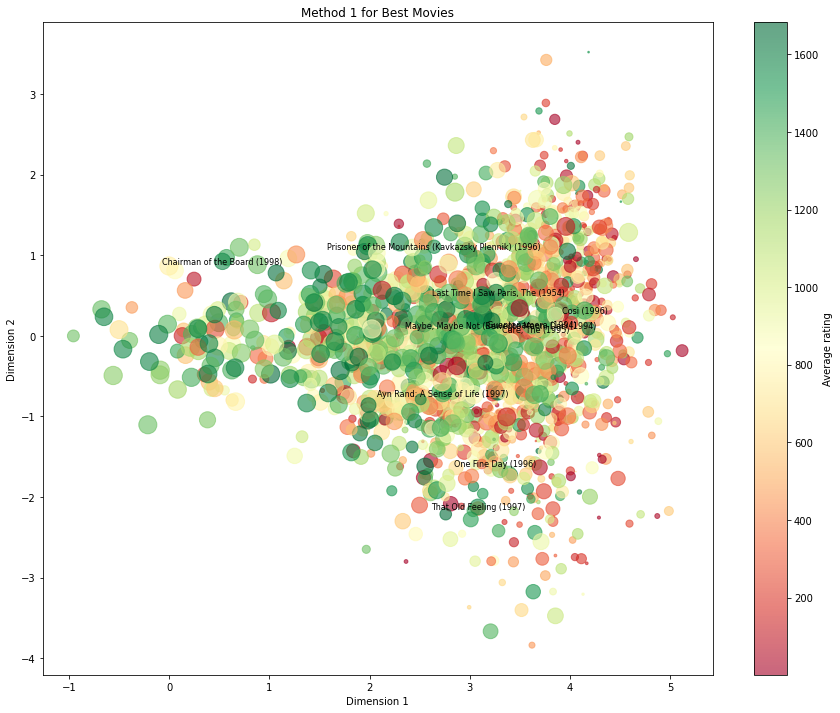

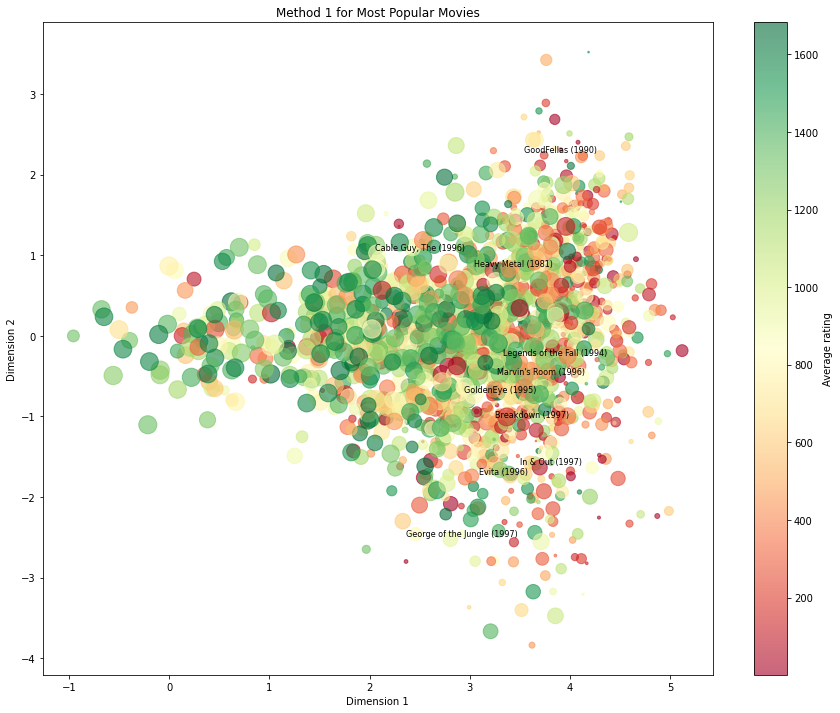

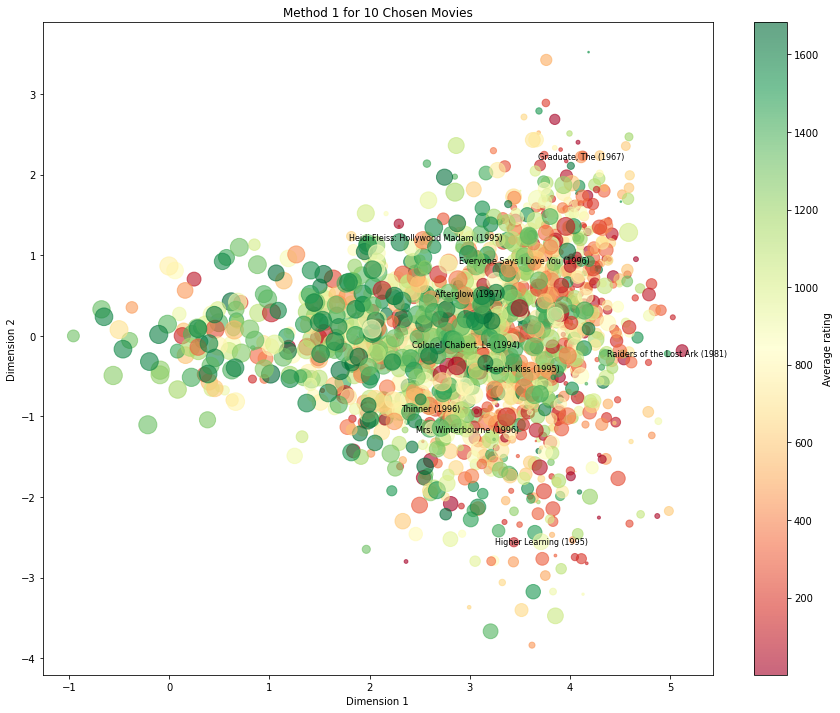

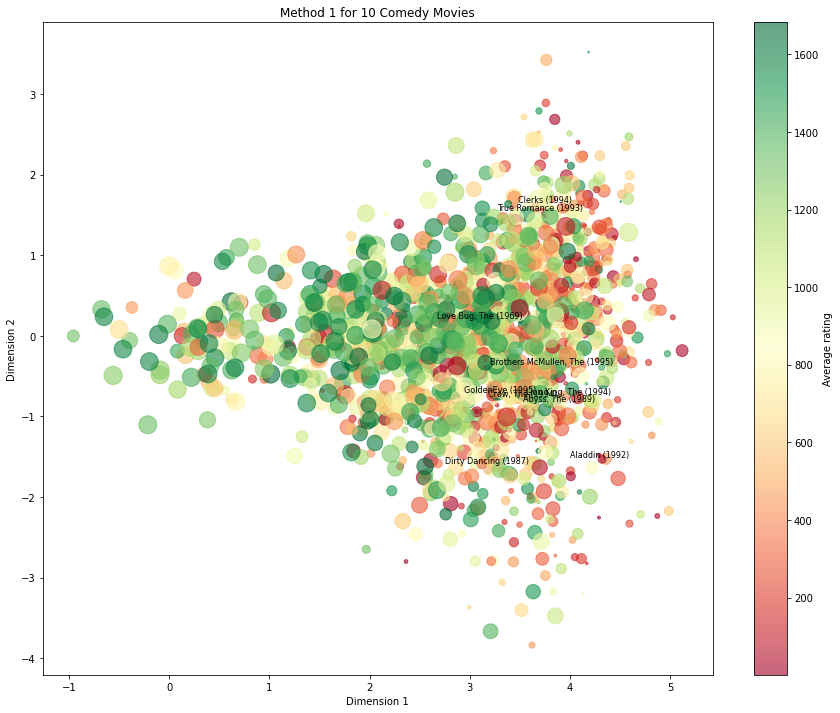

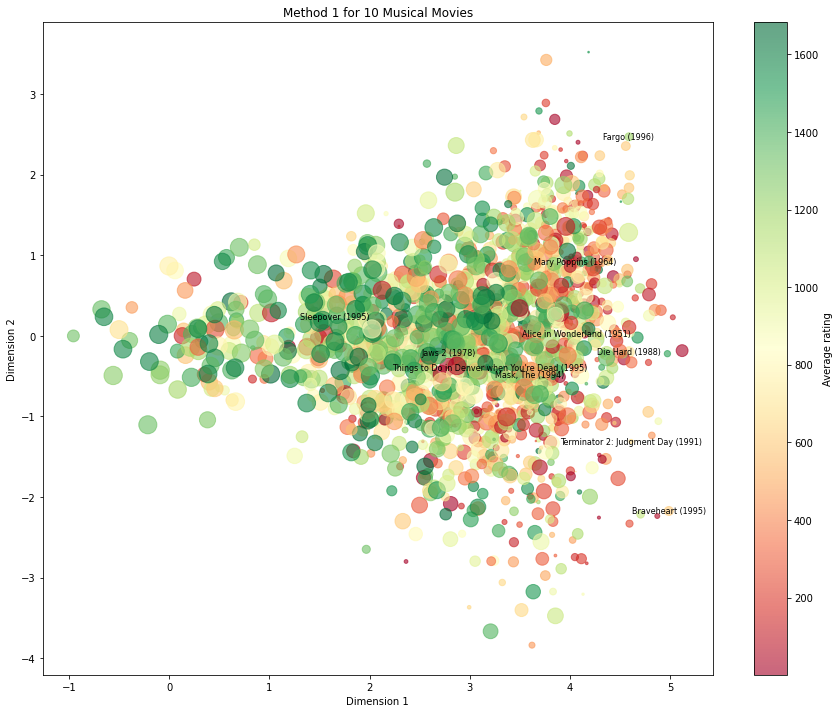

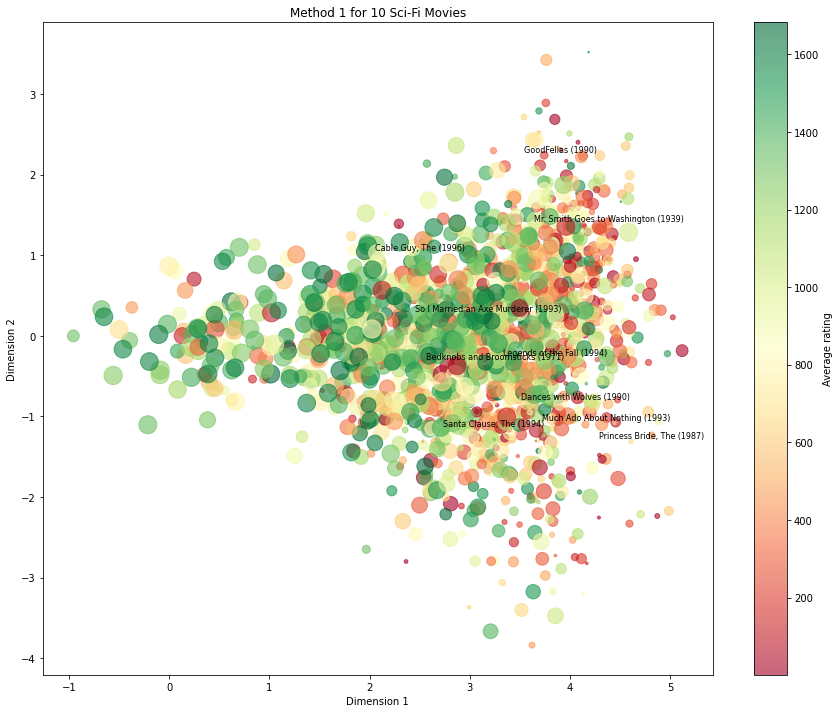

In [9]:

ten_popular = get_most_popular()[:10]
ten_best = get_highest_rated()[:10]
choice = get_choice_of_movies()
comedy = get_comedy_movies()
musical = get_musical_movies()
scifi = get_scifi_movies()
plot(V_proj, ten_best, 'Method 1 for Best Movies')
plot(V_proj, ten_popular, 'Method 1 for Most Popular Movies')
plot(V_proj, choice, 'Method 1 for 10 Chosen Movies')
plot(V_proj, comedy, 'Method 1 for 10 Comedy Movies')
plot(V_proj, musical, 'Method 1 for 10 Musical Movies')
plot(V_proj, scifi, 'Method 1 for 10 Sci-Fi Movies')